In [1]:
##########################################
###### Import all necessary modules ######
##########################################


import torch
from  torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import time
import tarfile

In [2]:
##################################
###### Create Dataset Class ######
##################################

class SVHNDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        self.data_csv = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.data_csv)
    
    def __getitem__(self, idx):
        img_name = os.path.join(os.path.split(os.getcwd())[0], 'data', self.data_csv['filename'][idx].replace("/", "\\"))
        image = Image.open(img_name) #image=Image.open(img_name)
        
        height=[]
        width=[]
        top=[]
        left=[]

        for i in range(5):
            bb = self.data_csv['bbox%d'%(i+1)][idx]
            bb = bb[1:(len(bb)-1)]
            bb = bb.split(',')
            bb = [float(element) for element in bb]
            height.append(bb[3])
            width.append(bb[2])
            top.append(bb[1])
            left.append(bb[0])
            
        new_left = [ii for ii in left if ii != 0]
        new_top = [ii for ii in top if ii != 0]
        
        if new_left==[]:
            new_left.append(0)
        
        if new_top==[]:
            new_top.append(0)
            
        _left = int(min(new_left))
        upper = int(min(new_top))
        right = int(max(left)) + int(max(width))
        lower = int(max(top)) + int(max(height))
        
        _image = image.crop(box=(_left, upper, right, lower))
        #_image = image.crop(box=(52,9,107,55))
        
        labels=[]
        labels.append(int(self.data_csv['len'][idx]))
        
        for i in range(5):
            num = self.data_csv['num%d'%(i+1)][idx]
            labels.append(int(num)+1)
            
        #resize and convert to np array
        _image = _image.resize([64,64])
        image_array = np.array(_image)
        #_image = image_array.reshape([64, 64, 3])
        image_array = Image.fromarray(image_array) #image_array = np.array(_image)
        labels_array = np.array(labels)
        labels_array = torch.from_numpy(labels_array).long()
        #labels_array = labels_array.type(torch.LongTensor)
        
        sample = {'image':image_array, 'labels': labels_array}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            #sample['labels'] = self.transform(sample['labels'])
            #sample = self.transform(sample)
            
        return sample

tensor([2, 6, 8, 0, 0, 0])


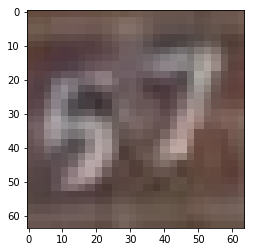

In [3]:
##################################
#### View Test Image Sample #####
##################################
test_dataset = SVHNDataset('test.csv')
test_sample = test_dataset.__getitem__(1020)
plt.imshow(test_sample['image'])
print(test_sample['labels'])

#Note that the labels are: original_label + 1

tensor([2, 6, 2, 0, 0, 0])


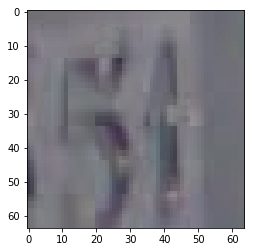

In [4]:
##################################
#### View Train Image Sample #####
##################################
train_dataset = SVHNDataset('train.csv')
train_sample = train_dataset.__getitem__(2003)
plt.imshow(train_sample['image'])
print(train_sample['labels'])

#Note that the labels are: original_label + 1

In [5]:
#####################################
# Define Transforms and DataLoaders #
#####################################

train_transforms= transforms.Compose([     
    #transforms.RandonCrop(54)        
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

test_transforms= transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

train_dataset = SVHNDataset('train.csv', transform=train_transforms)
test_dataset = SVHNDataset('test.csv', transform=test_transforms)


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [6]:
##################################
###### Defining Model Class ######
##################################
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden9 = nn.Sequential(
            nn.Linear(192 * 7 * 7, 3072),
            nn.ReLU()
        )
        hidden10 = nn.Sequential(
            nn.Linear(3072, 3072),
            nn.ReLU()
        )

        self._features = nn.Sequential(
            hidden1,
            hidden2,
            hidden3,
            hidden4,
            hidden5,
            hidden6,
            hidden7,
            hidden8
        )
        self._classifier = nn.Sequential(
            hidden9,
            hidden10
        )
        self._digit_length = nn.Sequential(nn.Linear(3072, 6))
        self._digit1 = nn.Sequential(nn.Linear(3072, 11))
        self._digit2 = nn.Sequential(nn.Linear(3072, 11))
        self._digit3 = nn.Sequential(nn.Linear(3072, 11))
        self._digit4 = nn.Sequential(nn.Linear(3072, 11))
        self._digit5 = nn.Sequential(nn.Linear(3072, 11))

    def forward(self, x):
        x = self._features(x)
        x = x.view(x.size(0), 192 * 7 * 7)
        x = self._classifier(x)

        length_logits, digits_logits = self._digit_length(x), [self._digit1(x),
                                                               self._digit2(x),
                                                               self._digit3(x),
                                                               self._digit4(x),
                                                               self._digit5(x)]
        return length_logits, digits_logits

In [7]:
################################
### Check Cuda Availability ####
################################
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [8]:
##################################
###### Define loss function ######
##################################

def _loss(length_logits, digits_logits, labels):
    length_cross_entropy = torch.nn.functional.cross_entropy(length_logits, labels[:,0])
    digit1_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[0], labels[:,1])
    digit2_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[1], labels[:,2])
    digit3_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[2], labels[:,3])
    digit4_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[3], labels[:,4])
    digit5_cross_entropy = torch.nn.functional.cross_entropy(digits_logits[4], labels[:,5])
    loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy
    return loss


In [9]:
############################################
###### Define Early Stopping Function ######
############################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        SVHN_model_checkpoint={'model_state_dict':model.state_dict(), 
                       'optimizer_state_dict': optimizer.state_dict(),
                       'train_losses':train_losses,
                       'test_losses':test_losses,
                       'training_time':training_time,
                       'no_of_steps':no_of_steps,
                       }
        
        torch.save(SVHN_model_checkpoint, 'SVHN_model_checkpoint.tar')
        self.val_loss_min = val_loss


In [ ]:
################################
###### Training the Model ######
################################

model = Model()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
early_stopping = EarlyStopping(patience=10, verbose=True)

if os.path.isfile('SVHN_model_checkpoint.tar'):
    print('SVHN_model_checkpoint.tar found..')
    print('Loading checkpoint..')
    checkpoint = torch.load('SVHN_model_checkpoint.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    training_time = checkpoint['training_time']
    no_of_steps = checkpoint['no_of_steps']
    print('Finished loading checkpoint..')
else:
    train_losses = []
    test_losses = []
    training_time = 0
    no_of_steps = 0
    

running_loss = 0
accuracy = 0
print_every = 1
test_loss_min = np.Inf

while True:
    start = time.time()
    #loop through the whole tranloader
    for sample in trainloader:
        no_of_steps += 1
        
        image = sample['image']
        labels = sample['labels']
        
        image, labels = image.to(device), labels.to(device)
        
        
        optimizer.zero_grad()
        
        length_logits, digits_logits = model.forward(image)
        loss = _loss(length_logits, digits_logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if no_of_steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            num_correct = 0
            needs_include_length = False
            
            model.eval()
            with torch.no_grad():
                for sample in testloader:
                    
                    image = sample['image']
                    labels = sample['labels']
                    
                    image, labels = image.to(device), labels.to(device)
                    
                    
                    length_logits, digits_logits = model.forward(image)
                    batch_loss = _loss(length_logits, digits_logits, labels)
                                      
                    test_loss += batch_loss.item()
                    
                    
                    # Calculate accuracy
                                    
                    _, length_top_class = length_logits.topk(1, dim=1)
                    
                    digits_top_class = []
                    
                    for i in range(5):
                      _, _digits_top_class = digits_logits[i].topk(1, dim=1)
                      digits_top_class.append(_digits_top_class)
                    
                    equals = length_top_class == labels[:,0].view(*length_top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    for i in range(5):
                        equals = digits_top_class[i] == labels[:,i+1].view(*digits_top_class[i].shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                   
            test_losses.append(test_loss/len(testloader))        
            train_losses.append(running_loss/print_every)
            training_time += (time.time() - start)
            valid_loss = test_loss/len(testloader)
            
            print(f"Steps {no_of_steps}.. "
                  f"Training time(secs) {training_time/60:.3f}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {valid_loss:.3f}.. "
                  f"Test accuracy: {accuracy/(6*len(testloader)):.3f}")
            
            early_stopping(valid_loss, model)
            
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
            running_loss = 0
            model.train()
        